In [1]:
import pandas as pd

# Наш план

### Сейчас, за короткие сроки, взять предобученную модель с Hugging Face, обучить ее на плюс-минус похожих датасетах, а потом к очному туру закинуть в модель автоперевода(выбрать наилучшую) датасет наиболее близкий к нашему домену (реддит и твиттер) и адаптировать все под русский - превалирующий язык аудитории ВК

In [2]:
import torch

In [3]:
device=torch.device('cpu')

In [4]:
device

device(type='cpu')

Есть причины, почему мы взяли Т5 от Гугла, а не GPT, вот несколько из них

- Т5 лучше себя показывает в задачах, которые требуют глубокого понимания текста(например в задаче суммаризации) за счет энкодера-декодера
- GPT - авторегрессионная модель, поэтому она лучше подходит для задач предсказания следующего слова и генерации, в то время как Т5 за счёт cross-attention может одновременно обращать внимание на разные места в тексте со схожой мыслью
- GPT хуже адаптируется к задачам, на которых он не был предварительно обучен и хуже работает с фактами, что критично для суммаризации, где-то может быть нелогичен
- Т5 лучше работает с фактами за счет более чистых данных, на которых он обучался

In [5]:
!pip install sentencepiece

In [6]:
!pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [25]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration


model_name = "sarahai/ruT5-base-summarizer"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
!pip install datasets

In [7]:
from datasets import load_dataset

dataset = load_dataset("rcp-meetings/rudialogsum_v2")

In [8]:
tokenizer('привет как дела')

{'input_ids': [5702, 27, 710, 2], 'attention_mask': [1, 1, 1, 1]}

In [9]:
max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    inputs = [doc for doc in examples["dialog"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [10]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [12]:
!pip install accelerate -U

In [11]:
!pip install transformers[torch]

zsh:1: no matches found: transformers[torch]


In [ ]:
from evaluate import load

metric = load("rouge")

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

ImportError: To be able to use evaluate-metric/rouge, you need to install the following dependencies['absl', 'rouge_score'] using 'pip install # Here to have a nice missing dependency error message early on rouge_score' for instance'

In [13]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

batch_size = 16
args = Seq2SeqTrainingArguments(
    "summarization_for_vk<3",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True)

In [14]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [ ]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id) #-100 там где не можем декодировать
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)

    result = {key: value * 100 for key, value in result.items()}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [19]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [21]:
trainer.train()

RuntimeError: MPS backend out of memory (MPS allocated: 8.79 GB, other allocations: 128.70 MB, max allowed: 9.07 GB). Tried to allocate 315.19 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [37]:
type(tokenizer)

transformers.models.t5.tokenization_t5.T5Tokenizer

In [27]:
!nvidia-smi

Fri Mar 29 22:22:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              31W /  70W |  15091MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [30]:
import torch

# Clear the CUDA memory cache
torch.cuda.empty_cache()

#### У нас возникли проблемы с нехваткой ресурсов для дообучения модели, мы пробовали обучать в гугл колабе с Т4 и на каггле с P100, в обоих случаях обучение крашилось из-за того, что сервер не позволял выделить достаточное количество памяти

Поэтому сейчас мы возьмем готовую модельку, встроим ее в бота и посмотрим, что получится, модель будем использовать прямо в боте через вызов пайплайна, реализация - в ветке с суммаризацией

А если пройдем на очный тур, то на серверах сириуса сможем полностью дообучить LLM, получив полностью готовый продукт в экосистеме вк

In [17]:
!pip install protobuf

Python(26486) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.0/404.0 kB 750.5 kB/s eta 0:00:0000:0100:01


In [32]:
# Use a pipeline as a high-level helper
from transformers import pipeline
text=''' вот сейчас моё настроение не зависит от ожидания чьих-то сообщений, настроения кого-либо, я ни с кем не ссорюсь и даже конфликтов не имею, не смотрю на цифры на весах, ем что хочу и сколько хочу, не ограничиваю себя, я не завишу от мнения окружающих, даже не имею загонов глубоких… я почти всегда в приподнятом настроении, очень редко грущу и уже более трех месяцев я не испытывала долгих грустных периодов, у меня очень крепкое стабильное эмоциональное состояние хахаха
самое глупое, что мне даже как-то скучно от этого, я просто завишу от себя, просто занимаюсь тем, чем хочу, если что-то идет не так, то это ток моя вина и даж не обидеться ни на кого, да и не хочется,
это что? это всё потому что лето на улице)
'''
pipe = pipeline("summarization", model="sarahai/ruT5-base-summarizer",tokenizer=tokenizer)
pipe(text,min_length=5, max_length=100)[0]['summary_text']

'Когда я нахожусь в отпуске, я всегда в приподнятом настроении, ни с кем не ссорюсь и даже не завишу от мнения окружающих, я просто занимаюсь тем, чем хочу и сколько хочу, не ограничиваю себя ни чем.'

Как видно, пока что модель показывает себя средне при суммаризации сообщений, за счет их специфики, но я думаю, что это исправится при дообучении на должном количестве данных

# На удачу

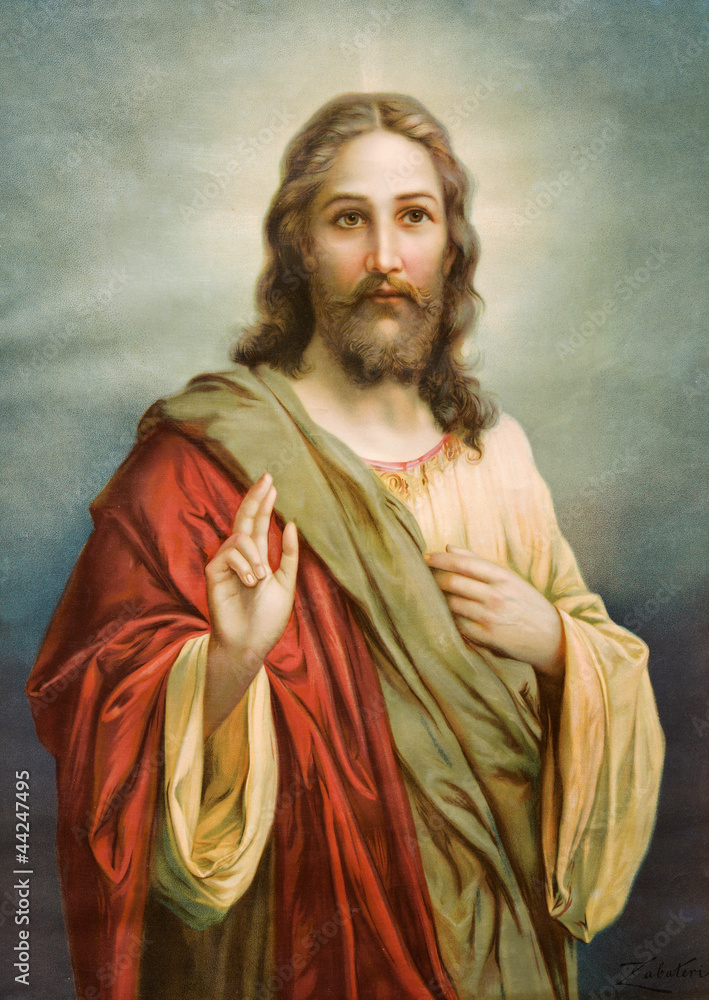

In [33]:
from IPython import display
display.Image("../secret_feature/jesus.jpg",width=10,height=70)